### TOPIC MODELING WITH BERTOPIC ALGORITHM - CSAT DATA

In [ ]:
# Importing necessary libraries/packages
import numpy as np
import pandas as pd
import scipy as scs
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
import datetime as dt
import re

import gensim
from gensim.utils import simple_preprocess
import nltk

import gensim.corpora as corpora
from pprint import pprint

#import pyLDAvis.gensim_models
import pickle 
#import pyLDAvis

pd.set_option("display.max_columns", 50, "display.max_rows", 100)

In [ ]:
# Authentication
from google.colab import auth
auth.authenticate_user()

In [ ]:
#Importing data from bigquery
from google.cloud import bigquery
proj_name = 'pg-duke-student-capstone-v1'
proj_num = '545682952716'
proj_id =   'pg-duke-student-capstone-v1'
client = bigquery.Client(project=proj_id)

#fact_csat

In [ ]:
# Reading data from big query

#sql_query_csat = ('''SELECT *
#                FROM pg-duke-student-capstone-v1.source_data.fact_csat
#                ''')

# Run a Standard SQL query with the project set explicitly
#project_id = 'pg-duke-student-capstone-v1'
#data = pd.read_gbq(sql, project_id=project_id, dialect='standard')
#data = pd.read_gbq(sql_query_csat, project_id=proj_id, dialect='standard')
#data.head(2)


# "pg-duke-student-capstone-v1.final_merged.clean_nps"

sql_query_csat = """
    WITH A AS
      (SELECT * FROM `pg-duke-student-capstone-v1.final_merged.cleaned_csat`)
      SELECT * FROM A
      -- limit 10"""

# Run a Standard SQL query with the project set explicitly
project_id = 'pg-duke-student-capstone-v1'
#data = pd.read_gbq(sql, project_id=project_id, dialect='standard')
data = pd.read_gbq(sql_query_csat, project_id=proj_id, dialect='standard')
#data.head()

In [ ]:
# Look at dimensions of the data
print(data.shape)

(6372, 20)


In [ ]:
# Quick browse of customer reviews
#data["comment"]

In [ ]:
# Removing the "Nones'
data = data[~data["comment"].astype(str).eq('None')]

In [ ]:
#Also drop nas and missing strings from data
# drop rows containing "nas" or empty strings
data = data.dropna(subset=["comment"], axis=0).reset_index(drop=True)

# display the updated DataFrame
print(data.shape)

(3484, 20)


In [ ]:
# Dimensions of data after removing nones (data drops by alomst half)
print(data.shape)

(3484, 20)


In [ ]:
# Converting the timestamps to day, month and year for later use
data['date'] = pd.to_datetime(data['response_timestamp'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
# df_nps["month-year"] = df_nps.month.astype(str) + "-" + df_nps.year.astype(str)

In [ ]:
# Categorize the score - No is not an important step though
data["score_categorized"] = pd.cut(data.score, bins=[-np.inf, 6, 8, 10],
                  labels=["detractor", "passive", "promoter"])


In [ ]:
# Check data to see the changes made above
#data.head(2)

In [ ]:
# Check distribution of scores 
data["score"].value_counts()

1.0    1762
5.0     852
2.0     375
3.0     276
4.0     219
Name: score, dtype: int64

In [ ]:
## We see that the scores are all low, could it be related to nps scores for detractors ??
#data['score_categorized'].value_counts()

In [ ]:
## Saving the clean data from later
data_clean = data.copy()  
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3484 entries, 0 to 3483
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   response_id                         3484 non-null   Int64              
 1   name                                3277 non-null   object             
 2   email                               3484 non-null   object             
 3   score                               3484 non-null   float64            
 4   comment                             3484 non-null   object             
 5   response_timestamp                  3484 non-null   datetime64[ns, UTC]
 6   notes                               0 non-null      object             
 7   tags                                0 non-null      object             
 8   additional_question                 0 non-null      object             
 9   application_id                      3484 

In [ ]:
#Optional steps
#The BERTopic class expects text data in the form of a list of strings containing documents. 
#Therefore, we convert the customer review dataset to a list of strings.
data_csat_ = data["comment"].tolist()

In [ ]:
# Read the first four reviews
#data_csat_[0:5]

In [ ]:
## convert from list to string. This string text will help us contectualize topics emerging leter from the algorithm
#data_csat_1 = "".join(data_csat_)
#data_csat_1

In [ ]:
# Create a new column containing the length each review text and find the longest review text
data["comment_len"] = data["comment"].apply(lambda x : len(x.split()))
len(data["comment_len"])
print("The longest headline has: {} words".format(data.comment_len.max()))

The longest headline has: 390 words


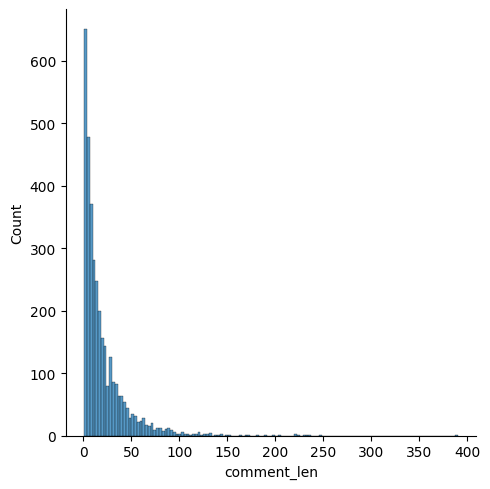

In [ ]:
# Visualize the length distribution 
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data.comment_len, kde=False)

## DATA PREPROCESSING 

In [ ]:
# install contractions
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 19.3 MB/s eta 0:00:00


In [ ]:
### Importing necessary libraries
import pandas as pd
import nltk
import string
#stopwords
from nltk.corpus import stopwords
#tokenizer
from nltk.tokenize import RegexpTokenizer
#lemmatizer
from nltk.stem import WordNetLemmatizer
#Stemmer
from nltk.stem.porter import PorterStemmer

#contractions
import contractions

#gensims
import gensim
from gensim import models
from gensim.utils import simple_preprocess

In [ ]:
#download stop words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# download word net for lemmatizing
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
#DATA PREPROCESSING STEPS
### Removing stopwords, tokenizing data, lemmaziting, converting to lower case, remove panctuations, i 

stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 'use', 'policygenius', 'policy', 'genius','insurance', "pg", 'none', 'na', "able", "already", "also",
                   "was", "were", "thus", "although", "always", "bc", "because", "definitely", "could", "couldnt", 'would', "wouldnt"])

def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split('/')]))
    
    # remove emojis
    #text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in stop_words if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    from nltk.stem import WordNetLemmatizer
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # stemming
    #from nltk.stem import PorterStemmer
    #text_col = text_col.apply(lambda x: ' '.join([PorterStemmer().stem(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

In [ ]:
# view one instance
data["comment"][3]

'Not interests'

In [ ]:
len(data)

3484

In [ ]:
# Calling the data preprocessing function above and visualizing same instance as above
csatdata_clean = preprocess(data["comment"])  #[3] # L + stemming
csatdata_clean[3]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


'not interest'

In [ ]:
len(csatdata_clean)

3484

### BERTOPIC ALGORITHM

In [ ]:
#The first step for creating a Topic Model with BERTopic is to import the BERTopic class from the bertopic module.
!pip install bertopic
from bertopic import BERTopic
!pip install joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 64.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   

In [ ]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

### ANALYSIS OF CUSTOMER REVIEWS (CSAT DATA) USING BERTOPIC 

In [ ]:
##Quick check through the data we are using
csatdata_clean.head()
len(csatdata_clean)

3484

In [318]:
# BERTopic actually requires data in an array format. We convert the data frame texts into a numpy array object.
csatdata_clean1 = np.array(csatdata_clean)   
#csatdata_clean1

In [ ]:
#Quick check that the length of data is maintained
len(csatdata_clean1)

3484

In [ ]:
# Removing Nas and empty lists from data (Optional step)
#csatdata_clean2 = [x for x in csatdata_clean1 if x not in (None, '')]
# display the updated array
#len(csatdata_clean2)

In [ ]:
## Importing the necessary packages for the Bertopic module
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

#### Functions and parameters for tuning

In [ ]:
# Define function for parameters

def create_model(embedding_model_name, umap_params, hdbscan_params, vectorizer_params, ctfidf_params, representation_params):
    # Step 1 - Extract embeddings
    embedding_model = SentenceTransformer(embedding_model_name)
    
    # Step 2 - Reduce dimensionality
    umap_model = UMAP(**umap_params)
    
    # Step 3 - Cluster reduced embeddings
    hdbscan_model = HDBSCAN(**hdbscan_params)
    
    # Step 4 - Tokenize topics and create ngrams
    vectorizer_model = CountVectorizer(**vectorizer_params)
    
    # Step 5 - Create topic representation
    ctfidf_model = ClassTfidfTransformer(**ctfidf_params)
    
    # Step 6 - (Optional) Fine-tune topic representations with 
    # a `bertopic.representation` model
    representation_model = KeyBERTInspired(**representation_params)
    
    return embedding_model, umap_model, hdbscan_model, vectorizer_model, ctfidf_model, representation_model

In [ ]:
# Defining parameters using function above (We do this to avoid instantiating parameters everytime)

# First set of parameters
umap_params_1 = {'random_state': 150, 'n_neighbors': 15, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine'}
hdbscan_params_1 = {'min_cluster_size': 17, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}
vectorizer_params_1 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_1 = {}
representation_params_1 = {}

embedding_model_1, umap_model_1, hdbscan_model_1, vectorizer_model_1, ctfidf_model_1, representation_model_1 = create_model(
    "all-MiniLM-L6-v2", umap_params_1, hdbscan_params_1, vectorizer_params_1, ctfidf_params_1, representation_params_1)

# Second set of parameters
umap_params_2 = {'random_state': 150, 'n_neighbors': 15, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine'}
hdbscan_params_2 = {'min_cluster_size': 12, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}
vectorizer_params_2 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_2 = {}
representation_params_2 = {}

embedding_model_2, umap_model_2, hdbscan_model_2, vectorizer_model_2, ctfidf_model_2, representation_model_2 = create_model(
    "all-MiniLM-L6-v2", umap_params_2, hdbscan_params_2, vectorizer_params_2, ctfidf_params_2, representation_params_2)


# Third set of parameters
umap_params_3 = {'random_state': 150, 'n_neighbors': 15, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine'}
hdbscan_params_3 = {'min_cluster_size': 15, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}
vectorizer_params_3 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_3 = {}
representation_params_3 = {}

embedding_model_3, umap_model_3, hdbscan_model_3, vectorizer_model_3, ctfidf_model_3, representation_model_3 = create_model(
    "all-MiniLM-L6-v2", umap_params_3, hdbscan_params_3, vectorizer_params_3, ctfidf_params_3, representation_params_3)


# Fourth set of parameters
umap_params_4 = {'random_state': 150, 'n_neighbors': 15, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine'}
hdbscan_params_4 = {'min_cluster_size': 18, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}
vectorizer_params_4 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_4 = {}
representation_params_4 = {}

embedding_model_4, umap_model_4, hdbscan_model_4, vectorizer_model_4, ctfidf_model_4, representation_model_4 = create_model(
    "all-MiniLM-L6-v2", umap_params_4, hdbscan_params_4, vectorizer_params_4, ctfidf_params_4, representation_params_4)


# Fifth set of parameters
umap_params_5 = {'random_state': 150, 'n_neighbors': 50, 'n_components': 5, 'min_dist': 0.0, 'metric': 'cosine'}
hdbscan_params_5 = {'min_cluster_size': 100, 'metric': 'euclidean', 'cluster_selection_method': 'eom', 'prediction_data': True}
vectorizer_params_5 = {'stop_words': 'english', 'ngram_range': (2, 3)}
ctfidf_params_5 = {}
representation_params_5 = {}

embedding_model_5, umap_model_5, hdbscan_model_5, vectorizer_model_5, ctfidf_model_5, representation_model_5 = create_model(
    "all-MiniLM-L6-v2", umap_params_5, hdbscan_params_5, vectorizer_params_5, ctfidf_params_5, representation_params_5)



#### Function for coherence

In [ ]:
import pandas as pd
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic

# coherence score in topic modeling to measure how interpretable the topics are to humans.
# coherence score - Evaluate the semantic coherence of a set of topics by measuring the degree of semantic similarity between the top words in each topic. 
# A high coherence score implies -  that the topics are more coherent, words within each topic are more semantically related, 
# A high coherence score implies - generated topics are more interpretable, useful for downstream tasks e.g document clustering, classification, or retrieval

# Function to create coherence score
def evaluate_coherence(docs, topics, topic_model):
    
    # Group docs by topic and preprocess them
    documents = pd.DataFrame({"Document": docs, "ID": range(len(docs)), "Topic": topics})
    documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document':' '.join})
    cleaned_docs = topic_model._preprocess_text(documents_per_topic.Document.values)


    # Extract vectorizer and analyzer from BERTopic
    vectorizer  = topic_model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    # Extract features for Topic Coherence evaluation
    #words = vectorizer.get_feature_names()
    tokens = [analyzer(doc) for doc in cleaned_docs]

    # Extract features for Topic Coherence evaluation
    dictionary = corpora.Dictionary(tokens)
    corpus = [dictionary.doc2bow(token) for token in tokens]
    topic_words = [[words for words, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

    # Removing any empty strings
    topic_words = [[x for x in sub_arr if x not in ('', None)] for sub_arr in topic_words]

    # Evaluate coherence
    coherence_model = CoherenceModel(topics=topic_words, texts=tokens, 
                                     corpus=corpus, dictionary=dictionary, coherence= 'c_v')
    coherence = coherence_model.get_coherence()
    
    return coherence

##MODELING

## OPTIMAL CLUSTER, 7

In [ ]:
## 7 TOPICS 
topic_model_detra = BERTopic(nr_topics= 8, 
  embedding_model = embedding_model_1,    # Step 1 - Extract embeddings
  umap_model = umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1,
  representation_model = representation_params_1,
   verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [ ]:
# produce topics and probablities
topics, probs = topic_model_detra.fit_transform(csatdata_clean1)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

2023-04-12 23:37:48,891 - BERTopic - Transformed documents to Embeddings
2023-04-12 23:38:14,063 - BERTopic - Reduced dimensionality
2023-04-12 23:38:14,213 - BERTopic - Clustered reduced embeddings
2023-04-12 23:38:16,622 - BERTopic - Reduced number of topics from 36 to 8


In [ ]:
## COHERENCE SCORE CALCULATION
coherence_score_7 = evaluate_coherence(csatdata_clean1, topics, topic_model_detra)
print(f"The coherence score is: {coherence_score_7}")

The coherence score is: 0.725474684674866


Coherence score thresholds are subjective and can vary depending on the domain, the size of the corpus, the type of the topic modeling algorithm, and other factors. However, there are some general rule-of-thumb guidelines for interpreting coherence scores in topic modeling:

Low coherence score: A coherence score less than 0.4 is generally considered to be low and indicates that the generated topics are not very interpretable or useful for downstream tasks.

Moderate coherence score: A coherence score between 0.4 and 0.6 is considered to be moderate and indicates that the generated topics are somewhat interpretable and may be useful for some downstream tasks.

High coherence score: A coherence score above 0.6 is generally considered to be high and indicates that the generated topics are highly interpretable and useful for downstream tasks.

It's important to note that these are rough guidelines, and the interpretation of coherence scores depends on many factors. For example, coherence scores tend to be lower for larger corpora, as there are more potential word co-occurrences that may not be semantically related. Additionally, coherence scores are not the only metric to consider when evaluating the quality of topic models; other factors, such as topic diversity, specificity, and relevance to the domain, should also be taken into account.

In [ ]:
#Plot Topics Visualization curve
#Topics Visualization.¶
#The topic visualization helps in gaining more insight about each topic. 
#BERTopic provides several visualization possibilities such as terms visualization, intertopic distance map, 
#topic hierarchy clustering just to name a few.
#The visual below could help guide the topic formulation process.
topic_model_detra.visualize_topics()

In [ ]:
#CSV for top n words
temp = topic_model_detra.get_document_info(csatdata_clean1)
temp["Topic"].value_counts()

-1    1322
 0     696
 1     520
 2     360
 3     281
 4     173
 5      80
 6      52
Name: Topic, dtype: int64

### Model accounting for noise and outliers

In [ ]:
from umap import UMAP
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
# Reduce outliers
topic_new = topic_model_detra.reduce_outliers(csatdata_clean1, topics)

100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


In [ ]:
new_topics = pd.DataFrame(topic_new)
new_topics.value_counts()

 0    817
 1    786
 2    551
-1    478
 3    350
 4    328
 6     91
 5     83
dtype: int64

## Tuning for clusters 10, 9, 8,6,5 and 4 

##Cluster 10

In [ ]:
## 10 TOPICS 
#Putting All steps together nr_topics=10
topic_model_detra_10 = BERTopic(nr_topics= 11, 
  embedding_model=embedding_model_2,    # Step 1 - Extract embeddings
  umap_model=umap_model_2,              # Step 2 - Reduce dimensionality
  hdbscan_model= hdbscan_model_2,        # Step 3 - Cluster reduced embeddings
  vectorizer_model= vectorizer_model_2,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_2,
  representation_model = representation_params_2, 
  verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [ ]:
# produce topics and probablities
topics_10, probs_10 = topic_model_detra_10.fit_transform(csatdata_clean1)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

2023-04-12 21:10:45,470 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:11:13,644 - BERTopic - Reduced dimensionality
2023-04-12 21:11:13,795 - BERTopic - Clustered reduced embeddings
2023-04-12 21:11:16,813 - BERTopic - Reduced number of topics from 59 to 11


In [ ]:
## COHERENCE SCORE CALCULATION
coherence_score_10 = evaluate_coherence(csatdata_clean1, topics_10, topic_model_detra_10)
print(f"The coherence score is: {coherence_score_10}")

The coherence score is: 0.7929495789573875


In [ ]:
topic_model_detra_10.visualize_topics()

##Cluster 9

In [ ]:
## 9 TOPICS  
#Putting All steps together nr_topics=9
topic_model_detra_9 = BERTopic(nr_topics= 10, 
  embedding_model=embedding_model_3,    # Step 1 - Extract embeddings
  umap_model=umap_model_3,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model_3,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model_3,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_3,
  representation_model = representation_params_3, 
  verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [ ]:
# produce topics and probablities
topics_9, probs_9 = topic_model_detra_9.fit_transform(csatdata_clean1)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

2023-04-12 21:12:42,125 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:13:08,146 - BERTopic - Reduced dimensionality
2023-04-12 21:13:08,290 - BERTopic - Clustered reduced embeddings
2023-04-12 21:13:10,600 - BERTopic - Reduced number of topics from 42 to 10


In [ ]:
## COHERENCE SCORE CALCULATION
coherence_score_9 = evaluate_coherence(csatdata_clean1, topics_9, topic_model_detra_9)
print(f"The coherence score is: {coherence_score_9}")

The coherence score is: 0.7161497046025276


In [ ]:
topic_model_detra_9.visualize_topics()

##Cluster 8

In [ ]:
## 8 TOPICS 
### Updating same model above for fewer  
#Putting All steps together nr_topics=7
topic_model_detra_8 = BERTopic(nr_topics= 9, 
  embedding_model=embedding_model_3,    # Step 1 - Extract embeddings
  umap_model=umap_model_3,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model_3,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model_3,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_3, 
  representation_model = representation_model_3,
  verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [ ]:
# Produce topics and probablities
topics_8, probs_8 = topic_model_detra_8.fit_transform(csatdata_clean1)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

2023-04-12 21:14:24,215 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:14:49,240 - BERTopic - Reduced dimensionality
2023-04-12 21:14:49,395 - BERTopic - Clustered reduced embeddings
2023-04-12 21:15:20,248 - BERTopic - Reduced number of topics from 42 to 9


In [ ]:
## COHERENCE SCORE CALCULATION
coherence_score_8 = evaluate_coherence(csatdata_clean1, topics_8, topic_model_detra_8)
print(f"The coherence score is: {coherence_score_8}")

The coherence score is: 0.47462963248935597


In [ ]:
topic_model_detra_8.visualize_topics()

##Cluster 6

In [ ]:
## 6 TOPICS  
#Putting All steps together nr_topics=6
topic_model_detra_6 = BERTopic(nr_topics= 7, 
  embedding_model=embedding_model_1,    # Step 1 - Extract embeddings
  umap_model=umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1, 
  representation_model = representation_model_1,
  verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [ ]:
# produce topics and probablities
topics_6, probs_6 = topic_model_detra_6.fit_transform(csatdata_clean1)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

2023-04-12 21:17:19,968 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:17:45,715 - BERTopic - Reduced dimensionality
2023-04-12 21:17:45,864 - BERTopic - Clustered reduced embeddings
2023-04-12 21:18:15,146 - BERTopic - Reduced number of topics from 36 to 7


In [ ]:
## COHERENCE SCORE CALCULATION
coherence_score_6 = evaluate_coherence(csatdata_clean1, topics_6, topic_model_detra_6)
print(f"The coherence score is: {coherence_score_6}")

The coherence score is: 0.2688204113823131


In [ ]:
topic_model_detra_6.visualize_topics()

##Cluster 5

In [ ]:
## 5 TOPICS  
#Putting All steps together nr_topics=5
topic_model_detra_5 = BERTopic(nr_topics= 6, 
  embedding_model=embedding_model_1,    # Step 1 - Extract embeddings
  umap_model=umap_model_1,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model_1,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model_1,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_1, 
  representation_model = representation_model_1,
  verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [ ]:
# produce topics and probablities
topics_5, probs_5 = topic_model_detra_5.fit_transform(csatdata_clean1)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

2023-04-12 21:19:29,524 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:19:53,657 - BERTopic - Reduced dimensionality
2023-04-12 21:19:53,899 - BERTopic - Clustered reduced embeddings
2023-04-12 21:20:20,912 - BERTopic - Reduced number of topics from 36 to 6


In [ ]:
## COHERENCE SCORE CALCULATION
coherence_score_5 = evaluate_coherence(csatdata_clean1, topics_5, topic_model_detra_5)
print(f"The coherence score is: {coherence_score_5}")

The coherence score is: 0.31522179115795707


In [ ]:
topic_model_detra_5.visualize_topics()

##Cluster 4

In [ ]:
## 4 TOPICS  
#Putting All steps together nr_topics=4
topic_model_detra_4 = BERTopic(nr_topics= 5, 
  embedding_model=embedding_model_4,    # Step 1 - Extract embeddings
  umap_model=umap_model_4,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model_4,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model_4,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model_4, 
  representation_model = representation_model_4,
  verbose = True)         #, verbose = True # Step 5 - Extract topic words.    ctfidf_model=ctfidf_model, verbose = True
  #diversity=0.8)                       # Step 6 - Diversify topic words). # representation_model=representation_model

In [ ]:
# produce topics and probablities
topics_4, probs_4 = topic_model_detra_4.fit_transform(csatdata_clean1)

Batches:   0%|          | 0/109 [00:00<?, ?it/s]

2023-04-12 21:21:10,287 - BERTopic - Transformed documents to Embeddings
2023-04-12 21:21:33,373 - BERTopic - Reduced dimensionality
2023-04-12 21:21:33,522 - BERTopic - Clustered reduced embeddings
2023-04-12 21:22:00,994 - BERTopic - Reduced number of topics from 36 to 5


In [ ]:
## COHERENCE SCORE CALCULATION
coherence_score_4 = evaluate_coherence(csatdata_clean1, topics_4, topic_model_detra_4)
print(f"The coherence score is: {coherence_score_4}")

The coherence score is: 0.40231882667886526


In [ ]:
topic_model_detra_4.visualize_topics()

### NOW EXPLORING THE MOST OPTIMAL MODEL (7 TOPICS)

-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, topic 0:

In [ ]:
## Using .get_document_info, we can also extract information on a document level, such as their corresponding topics, 
##probabilities, whether they are representative documents for a topic, etc.:
#topic_model_detra.get_document_info(csatdata_clean1)

In [ ]:
# Topic frequency and representation in documents
#freq = topic_model_detra.get_topic_info()
#print("Number of topics: {}".format( len(freq)))
#freq.head(8)

#The above table has 3 main columns, providing information about all the topics in descending order of topics size/Count.
#'Topic' is the topic number, a kind of identifier, and the outliers are labeled as -1. 
#Those are topics that should be ignored because they do not bring any added value.
#'Count' is the number of words in the topic.
#Name is the name given to the topic.

In [ ]:
#Visualize Topic Hierarchy
#As you can see in the Interdistance topic dashboard, some topics are very close. 
#One thing that could come to mind is how can I reduce the number of topics? 
#The good new is that those topics can be hierarchically in order to select the appropriate number of topics. 
#The visualization flavor helps to understand how they relate to one another.
#topic_model_detra.visualize_hierarchy()

In [ ]:
# Visualizing the Topic Terms 
# The most relevant words of each topic can be visualized in a form of barchart out of the c-TF-IDF score, 
#which is interesting to visually compare topics. Below is the corresponding visualization for the topic 7 topics.
#The longer the horizontal bar, the most relevant it is to the topic.
#topic_model_detra.visualize_barchart(top_n_topics=20, n_words =10, width = 400, height = 500)

In [ ]:
# Visualizing some incontext data per topic 
#docs = topic_model_detra.get_representative_docs()
#docs[3]

### DYNAMIC TOPIC MODELLING (Looking at topics overtime)


In [ ]:
# Start with looking at our original data 
#data_clean.head(2)

In [ ]:
# May need to create month year column
data_clean["month-year"] = data_clean.month.astype(str) + "-" + data_clean.year.astype(str)

In [ ]:
# Check reviews (optional step)
#data["comment"].value_counts()

In [ ]:
# Convert data to a numpy array
comment_detra = np.array(data_clean["comment"])

In [ ]:
# check length of data
len(comment_detra)

3484

In [ ]:
len(csatdata_clean1)

3484

In [ ]:
## Look at year variable distribution as we want to see topics over time
data_clean['year'].value_counts()
len(data_clean['year'])

3484

In [ ]:
#Making sure length of year is same as month-year
#data_clean1 = data_clean.dropna(subset=["comment"])
#len(data_clean1['year'])

In [ ]:
#check if variables were created
#data_clean.head(5)

In [ ]:
# Also convert the year variable into a numpy array 
year_data = np.array(data_clean['year'])
len(year_data)

3484

In [ ]:
# Also convert to year month array
month_year_data = np.array(data_clean['month-year']) 
len(month_year_data)

3484

In [ ]:
### Look at out model , which will be used in the process of DTM
topic_model_detra

In [320]:
#Collect data for merging below
data_clean_sub = data_clean[["response_timestamp", "comment"]]
#data_clean_sub.head()

##### Creating a CSV for tableau input

In [319]:
#CSV for top n words
barplotdata = topic_model_detra.get_document_info(csatdata_clean1)
#barplotdata.head()

In [ ]:
barplotdata1 = barplotdata.rename(columns={'Document': 'comment'})

In [ ]:
barplotdata1 = barplotdata1.rename(columns={'Topic': 'topic'})

In [ ]:
barplotdata1 = barplotdata1.rename(columns={'Top_n_words': 'top_n_words'})

In [ ]:
barplotdata1["group"] = "csat"

In [ ]:
#barplotdata1.head(2)

In [ ]:
#barplotdata1 = barplotdata1.rename(columns={'Top_n_words': 'top_n_words'})
barplotdata1['topic_desc'] = barplotdata1['Name'].replace({'-1_waste time_personal information_medical exam_email text': 'Outliers','0_customer service_great service_great experience_great job': '0 - Great Customer Service', '1_stop calling_bait switch_email text_time day': '1 - Excessive contact', '2_online quote_quote online_agent spoke_quote agent': '2 - Want online quotes not calls/talks','3_lower price_better rate_lower rate_price high': '3 - High quotes', '4_disappointed honest_honest say_honest honest_tell truth': '4 - Misled', '5_medical exam_medical record_exam required_exam needed': '5 - Discontent with medical exams', '6_social security number_security number_social security_personal information': '6 - Uncomfortable providing personal information'})


In [ ]:
# Pick required variables
barplotdata2 = barplotdata1[['group','topic','topic_desc','top_n_words']].copy()
#barplotdata2.head()

In [ ]:
data_clean_sub = data_clean_sub.rename(columns={'response_timestamp': 'date'})
#data_clean_sub.head()

In [ ]:
#Final CSV data for tableau
barplotdata3 = pd.concat([data_clean_sub,barplotdata2], axis=1)
#barplotdata3.head()

### Visualizing trends over time

In [ ]:
# Generating a data frame of topics over time - Years
topics_over_time_detra = topic_model_detra.topics_over_time(comment_detra, year_data, global_tuning=True,evolution_tuning=True) # global_tuning=True,evolution_tuning=True 


4it [00:00,  5.03it/s]


In [ ]:
# Generating a data frame of topics over time - Months
topics_over_monthyr_detra = topic_model_detra.topics_over_time(comment_detra, month_year_data, global_tuning=True,evolution_tuning=True) # global_tuning=True,evolution_tuning=True 


42it [00:07,  5.68it/s]


In [ ]:
#topics_over_monthyr_detra.head(2)

In [ ]:
# Look at the data description 
topics_over_time_detra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      32 non-null     int64 
 1   Words      32 non-null     object
 2   Frequency  32 non-null     int64 
 3   Timestamp  32 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ KB


In [ ]:
# Look at the data description 
topics_over_monthyr_detra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Topic      316 non-null    int64         
 1   Words      316 non-null    object        
 2   Frequency  316 non-null    int64         
 3   Timestamp  316 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 10.0+ KB


In [ ]:
## Visualize the topics over time
#topic_model_detra.visualize_topics_over_time(topics_over_time_detra, width =1250 , height = 500)   # top_n_topics=20

In [ ]:
## Visualize the topics over time
#topic_model_detra.visualize_topics_over_time(topics_over_monthyr_detra, width =1250 , height = 500)   # top_n_topics=20

## Generating ratio vs time period graphs

In [321]:
##Manipulate the data above to create the ratio (frequency/population)*100 in each year
#topics_over_time_detra.head()


In [ ]:
# Topics over time (YEARS)
topics_over_time_detra = topics_over_time_detra.drop(index=topics_over_time_detra[topics_over_time_detra['Topic'] == -1].index)
topics_over_time_detra["popn"] = topics_over_time_detra.groupby('Timestamp')['Frequency'].transform('sum')
topics_over_time_detra["ratio"] = topics_over_time_detra["Frequency"]/ topics_over_time_detra["popn"] 
#topics_over_time_detra['Name'] = topics_over_time_detra['Name'].replace({'0_customer service_great service_great e...': '0-Great CX', '1_stop calling_bait switch_email text_ti...': '1-Excessive contact', '2_online quote_quote online_agent spoke_...': '2-Want accurate online quotes','3_lower price_better rate_lower rate_pri...': '3-High quotes', '4_disappointed honest_honest say_honest ...': '4-Misleading', '5_medical exam_medical record_exam requi...': '5-Discontent with medical exams', '6_social security number_security number...': '6-Uncomfortable sharing personal info'})
topics_over_time_detra["Data"] = "CSAT"
#topics_over_time_detra = topics_over_time_detra.rename(columns={'Name': 'Topics'})

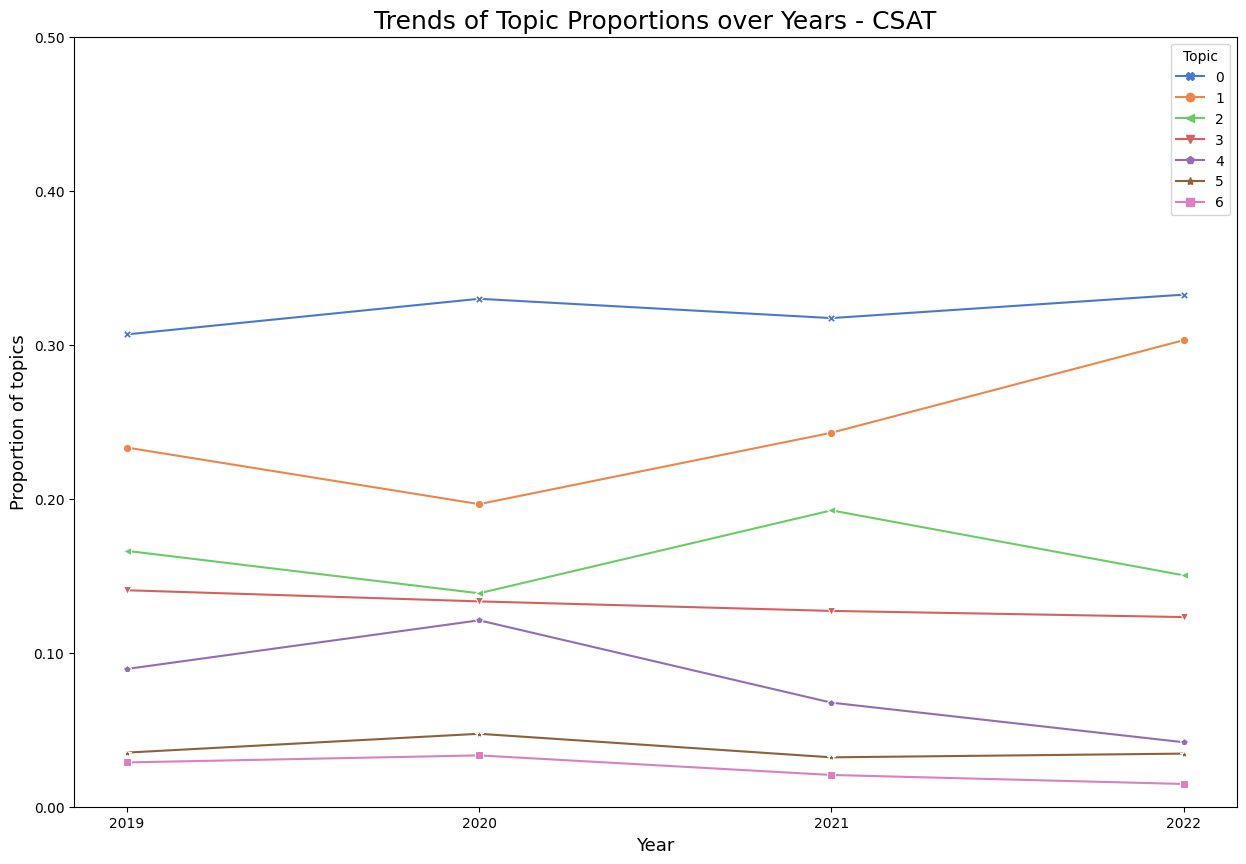

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# plot the data on ax2
fig, ax2 = plt.subplots(figsize=(15,10))
sns.lineplot(
    data=topics_over_time_detra, x="Timestamp", y="ratio", hue="Topic", 
    #palette=sns.color_palette("coolwarm", 7, saturation=1.5),
    palette="muted", ax=ax2,style="Topic", dashes=False, 
    #my_palette = sns.color_palette("coolwarm", desat=0.8),
    markers=["X", "o","<", "v","p","*","s"]
)

plt.xlabel("Year", fontsize=13)
ax2.set_ylabel('Proportion of topics', fontsize=13)
ax2.set_ylim(0.00, 0.50)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax2.set_xticks(range(topics_over_time_detra['Timestamp'].min(), topics_over_time_detra['Timestamp'].max()+1, 1))

plt.title("Trends of Topic Proportions over Years - CSAT", fontsize=18)

plt.show()

In [ ]:
# Topics over month year
topics_over_monthyr_detra = topics_over_monthyr_detra.drop(index=topics_over_monthyr_detra[topics_over_monthyr_detra['Topic'] == -1].index)
topics_over_monthyr_detra["popn"] = topics_over_monthyr_detra.groupby('Timestamp')['Frequency'].transform('sum')
topics_over_monthyr_detra["ratio"] = topics_over_monthyr_detra["Frequency"]/ topics_over_monthyr_detra["popn"] 
#topics_over_monthyr_detra['Name'] = topics_over_monthyr_detra['Name'].replace({'0_customer service_great service_great e...': '0-Great customer service and experience', '1_stop calling_bait switch_email text_ti...': '1-Excessive calls and texts', '2_online quote_quote online_agent spoke_...': '2-Want online quotes not calls/talks','3_lower price_better rate_lower rate_pri...': '3-High prices', '4_disappointed honest_honest say_honest ...': '4-Dishonest/ misled hence disappointment', '5_medical exam_medical record_exam requi...': '5-Discontent with medical exams', '6_social security number_security number...': '6-Uncomfortable providing social security number'})
topics_over_monthyr_detra["Data"] = "Detractors"
#topics_over_monthyr_detra = topics_over_monthyr_detra.rename(columns={'Name': 'Topics'})


Text(0.5, 1.0, 'Trends of Topic Proportions over Years - CSAT')

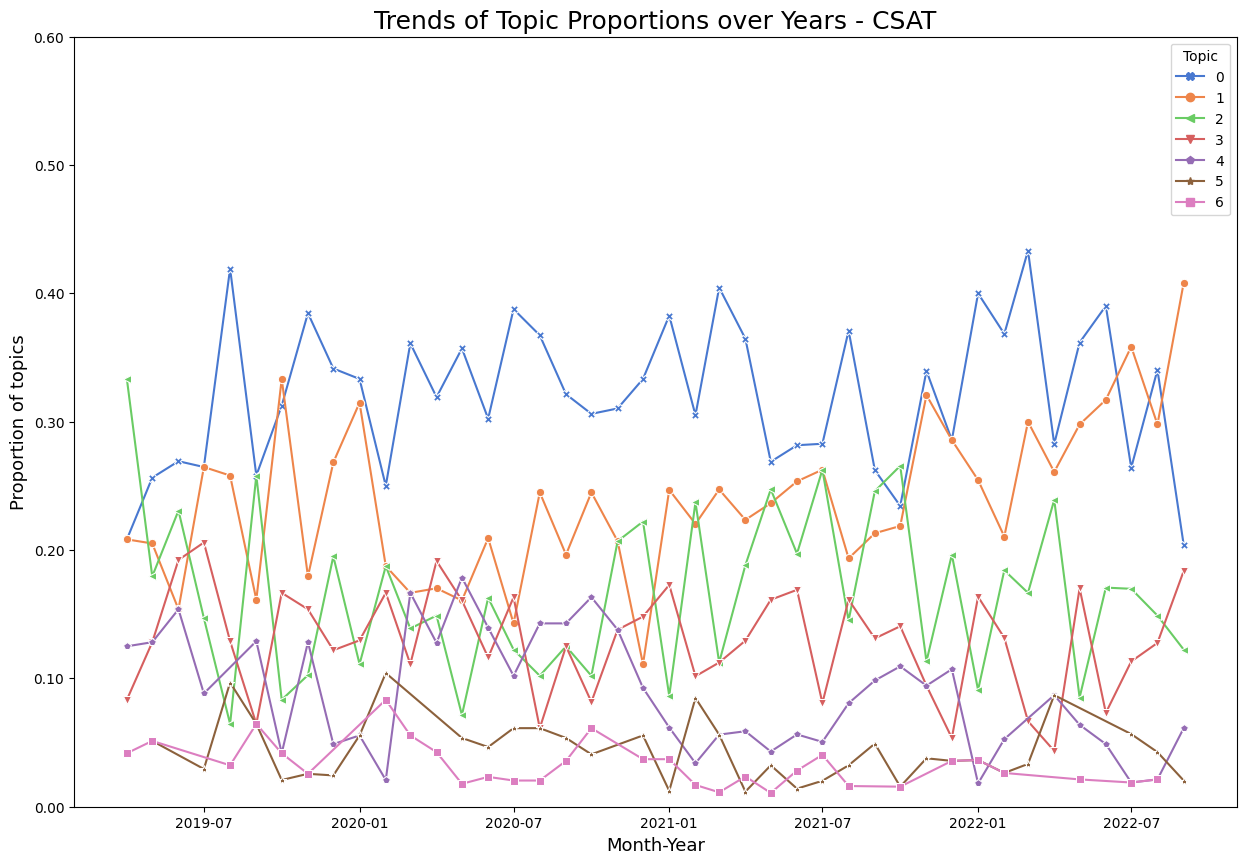

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# plot the data on ax2
fig, ax2 = plt.subplots(figsize=(15,10))
sns.lineplot(
    data=topics_over_monthyr_detra, x="Timestamp", y="ratio", hue="Topic", 
    #palette=sns.color_palette("coolwarm", 7, saturation=1.5),
    palette="muted", ax=ax2, style="Topic", dashes=False, 
    #my_palette = sns.color_palette("coolwarm", desat=0.8),
    markers=["X", "o","<", "v","p","*","s"]
)

plt.xlabel("Month-Year", fontsize=13)
ax2.set_ylabel('Proportion of topics', fontsize=13)
ax2.set_ylim(0.00, 0.60)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#ax2.set_xticks(range(topics_over_monthyr_detra['Timestamp'].min(), topics_over_monthyr_detra['Timestamp'].max()+1, 1))

plt.title("Trends of Topic Proportions over Years - CSAT", fontsize=18)

* Subplot figsize = (15,10)
* Y-axis – decimal points
* Y-axis title – Proportion of topics
* X-axis title – Year
* Plot title –”Trends of Topic Proportions over Years - [Group]”
* Palette - “muted”
* Legend position - top right
* Fontsize - axis labels - 13
* Fontsize - plot title - 18

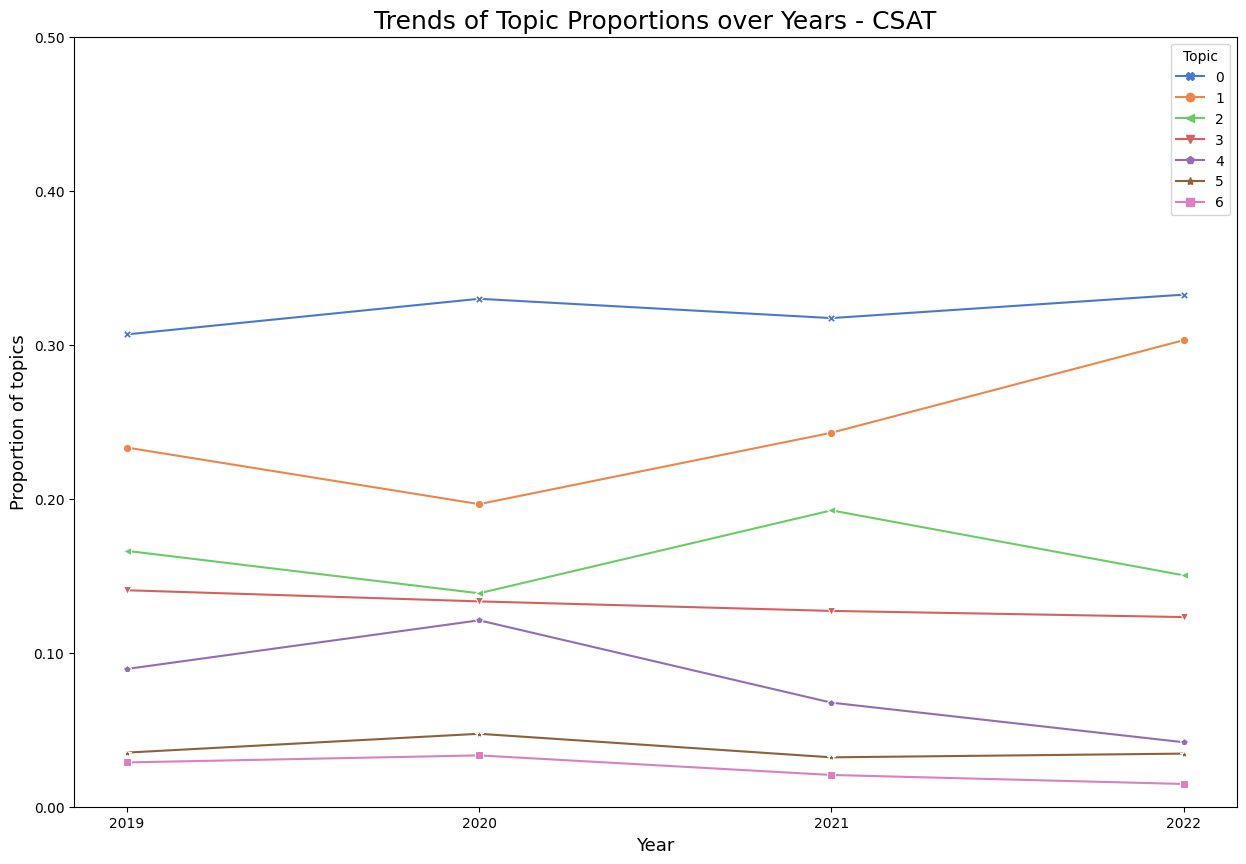

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# plot the data on ax2
fig, ax2 = plt.subplots(figsize=(15,10))
sns.lineplot(
    data=topics_over_time_detra, x="Timestamp", y="ratio", hue="Topic", 
    #palette=sns.color_palette("coolwarm", 7, saturation=1.5),
    palette="muted", ax=ax2, style="Topic", dashes=False, 
    #my_palette = sns.color_palette("coolwarm", desat=0.8),
    markers=["X", "o","<", "v","p","*","s"]
)

plt.xlabel("Year", fontsize=13)
ax2.set_ylabel('Proportion of topics', fontsize=13)
ax2.set_ylim(0.00, 0.50)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax2.set_xticks(range(topics_over_time_detra['Timestamp'].min(), topics_over_time_detra['Timestamp'].max()+1, 1))

plt.title("Trends of Topic Proportions over Years - CSAT", fontsize=18)

plt.show()

## SAVED MODEL AND CSV 

In [ ]:
## save this data for future retrieval
topics_over_time_detra.to_csv('/content/data_topics_overtime.csv') ##, index=False

In [ ]:
## save this data for future retrieval
topics_over_monthyr_detra.to_csv('/content/data_topics_monthyr.csv')

In [ ]:
# Saving
topic_model_detra.save('/content/topic_model_detra')

In [ ]:
# Loading
loaded_model = BERTopic.load('/content/topic_model_detra')

# END 